# Imports

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Loads

In [12]:
inputh_path='../../data'
df_train = pd.read_csv(f'{inputh_path}/df_train.csv', index_col=0)
df_validation = pd.read_csv(f'{inputh_path}/df_validation.csv', index_col=0)
df_validation_score = pd.read_csv(f'{inputh_path}/df_validation_score.csv', index_col=0)
df_data_type = pd.read_csv(f'{inputh_path}/df_data_type.csv', index_col=0)

# Define features and labels

In [27]:
X_train = df_train.drop(columns=['quality_category'], errors='ignore')  # Training features
y_train = df_train['quality_category']  # Training target labels (encoded)

X_validation = df_validation.drop(columns=['quality_category'], errors='ignore')  # Validation features
y_validation = df_validation['quality_category']

# Train model

In [34]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

In [35]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

# Test model

In [36]:
y_pred = rf_model.predict(X_validation)

In [37]:
print("y_validation type:", y_validation.squeeze().dtype)
print("y_pred type:", y_pred.dtype)
print("Unique values in y_validation:", y_validation.squeeze().unique())
print("Unique values in y_pred:", y_pred)

y_validation type: int64
y_pred type: int64
Unique values in y_validation: [4 3 2 1]
Unique values in y_pred: [4 3 3 3 3 4 3 2 1 2 2 3 2 2 4 2 2 3 3 2 1 2 2 3 3 3 2 3 3 2 2 1 2 3 3 2 2
 2 2 2 1 2 4 3 2 3 3 3 3 3 2 4 3 3 4 2 3 4 1 3 4 2 2 3 2 2 3 2 3 2 3 1 4 3
 2 3 2 3 3 2 4 3 3 2 2 1 1 3 1 3 2 2 3 2 1 2 2 2 2 3 3 3 3 1 3 2 4 2 4 3 2
 3 2 2 3 1 3 3 2 2 2 2 1 1 2 4 3 2 2 3 2 4 3 2 2 3 2 3 3 2 1 2 3 2 2 3 3 2
 2 2 4 3 3 2 3 3 2 2 4 3 1 2 1 3 2 2 2 3 3 3 3 3 2 3 2 2 3 4 3 3 2 2 2 1 2
 2 3 3 4 3 4 2 1 2 2 3 3 3 3 2 2 2 2 2 3 3 2 2 3 4 4 2 3 2 3 2 2 2 3 3 4 2
 1 2 3 3 2 3 2 2 3 2 1 2 3 3 1 3 4 3]


# Validation metrics

## Accuracy

In [38]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_validation, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9458333333333333


## Classification report

In [ ]:
from sklearn.metrics import classification_report

print("\nClassification Report:\n", 
      classification_report(y_validation, y_pred, target_names=['Low', 'Medium', 'High', 'Premium']))


Classification Report:
               precision    recall  f1-score   support

         Low       0.95      0.91      0.93        23
      Medium       0.95      0.94      0.95       102
        High       0.94      0.96      0.95        92
     Premium       0.96      0.96      0.96        23

    accuracy                           0.95       240
   macro avg       0.95      0.94      0.95       240
weighted avg       0.95      0.95      0.95       240



## ROC-AUC

In [44]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle

In [ ]:
y_validation_binarized = label_binarize(y_validation, classes=[1, 2, 3, 4])
n_classes = y_validation_binarized.shape[1]

y_validation_proba = rf_model.predict_proba(X_validation)

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict() 

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_validation_binarized[:, i], y_validation_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


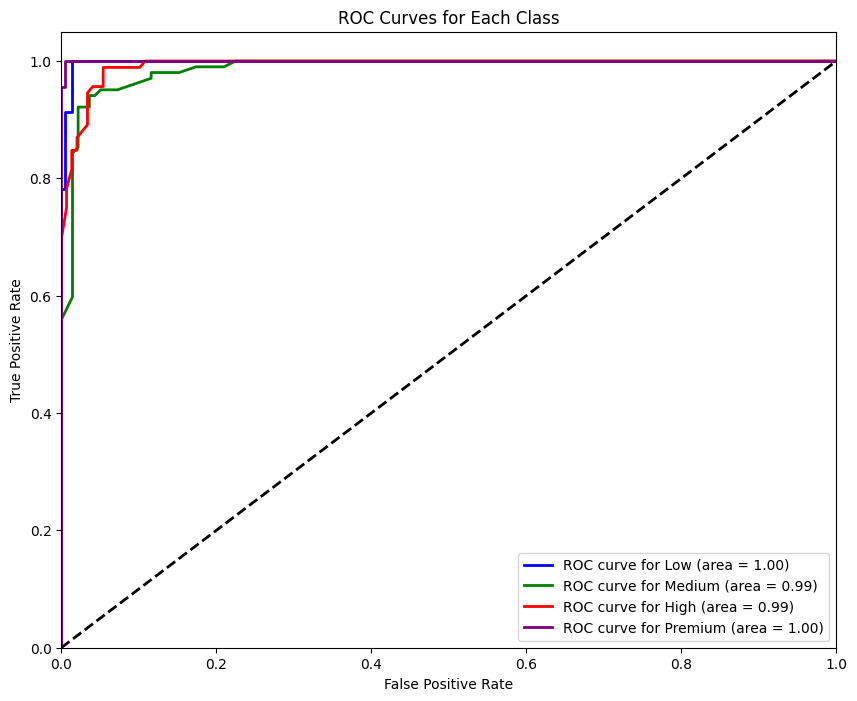

In [ ]:
plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'green', 'red', 'purple'])
class_names = ['Low', 'Medium', 'High', 'Premium']

for i, color, class_name in zip(range(n_classes), colors, class_names):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve for {class_name} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend(loc="lower right")
plt.show()

# Pseudo quality score

In [47]:
import numpy as np

In [45]:
class_scores = {
    1: 1.3,    # Midpoint of Low: 1.10 to 1.50
    2: 2.0,    # Midpoint of Medium: 1.51 to 2.50
    3: 3.0,    # Midpoint of High: 2.51 to 3.48
    4: 3.75    # Midpoint of Premium: 3.51 to 3.97
}

In [48]:
weights = np.array([class_scores[1], class_scores[2], class_scores[3], class_scores[4]])

In [53]:
y_validation_proba_df = pd.DataFrame(
    y_validation_proba, index=y_validation.index, columns=['Low', 'Medium', 'High', 'Premium'])

In [54]:
pseudo_quality_scores = y_validation_proba_df @ weights 

In [55]:
pseudo_quality_scores

1178    3.7200
865     2.9075
101     2.9450
439     2.8450
58      2.8350
         ...  
382     2.6305
867     1.3730
542     2.7475
1193    3.5550
874     2.7230
Length: 240, dtype: float64

In [60]:
df_validation_score

,quality_score
1178,3.530156
865,3.180000
101,3.160000
439,2.780000
58,2.870000
...,...
382,2.860000
867,1.490000
542,2.640000
1193,3.560807


In [62]:
df_pseudo_quality_scores = pd.DataFrame(pseudo_quality_scores, columns=['Pseudo Quality Score'])
comparison_df = pd.merge(df_validation_score, df_pseudo_quality_scores, left_index=True, right_index=True)
comparison_df.head(10)

,quality_score,Pseudo Quality Score
1178,3.530156,3.7200
865,3.180000,2.9075
101,3.160000,2.9450
439,2.780000,2.8450
58,2.870000,2.8350
1120,3.510000,3.6900
323,2.680000,2.5600
974,1.850000,1.9820
411,1.280000,1.5170
855,2.260000,2.1280


In [63]:
from sklearn.metrics import r2_score

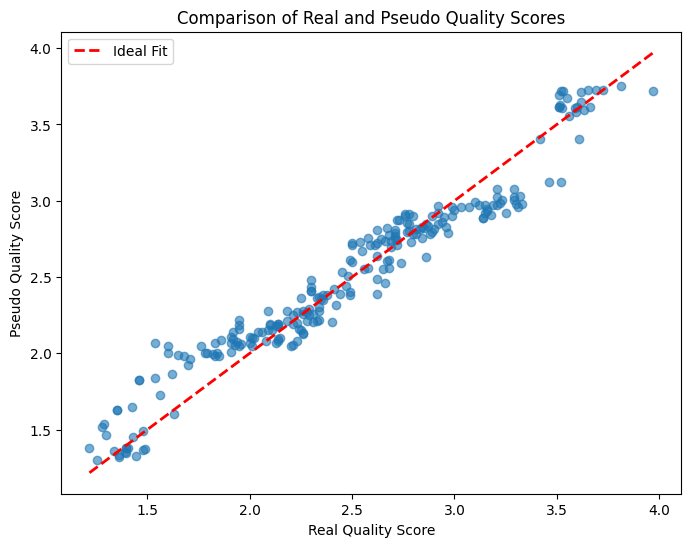

In [66]:
plt.figure(figsize=(8, 6))
plt.scatter(comparison_df['quality_score'], comparison_df['Pseudo Quality Score'], alpha=0.6)
plt.plot([comparison_df['quality_score'].min(), comparison_df['quality_score'].max()],
         [comparison_df['quality_score'].min(), comparison_df['quality_score'].max()],
         color='red', linestyle='--', linewidth=2, label="Ideal Fit")

plt.xlabel("Real Quality Score")
plt.ylabel("Pseudo Quality Score")
plt.title("Comparison of Real and Pseudo Quality Scores")
plt.legend()
plt.show()


In [68]:
r2 = r2_score(comparison_df['quality_score'], comparison_df['Pseudo Quality Score'])
print("R² (Coefficient of Determination):", r2)

R² (Coefficient of Determination): 0.940533938235513


## R² Value Interpretation (0.94)

    R² (Coefficient of Determination) is a metric that indicates the proportion of variance in the dependent variable (Real Quality Score) that can be explained by the independent variable (Pseudo Quality Score).
    
    An R² of 0.94 means that 94% of the variance in the real quality scores is explained by the pseudo quality scores derived from the model’s class probabilities.
    
    The fact that R² is close to 1 suggests a strong linear relationship between the real and pseudo scores, meaning that the pseudo score is a very good predictor of the real score.
    
    The remaining 6% of variance is due to unexplained differences between the pseudo and real scores, which could result from model limitations, data variability, or other subtle factors not captured by the pseudo score.

# But what decides the quality of the grape ?

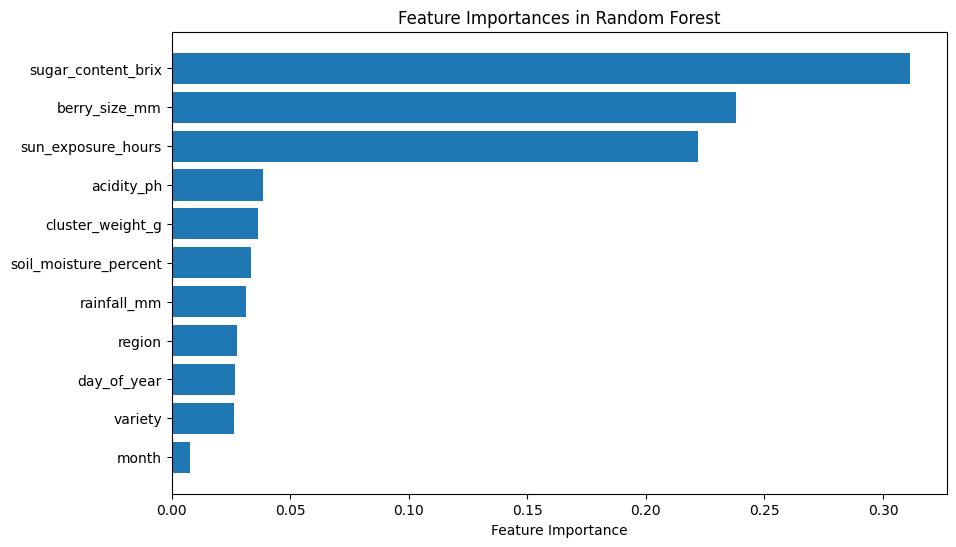

In [69]:
importances = rf_model.feature_importances_
feature_names = X_train.columns

# Sort features by importance
indices = np.argsort(importances)[::-1]
sorted_feature_names = [feature_names[i] for i in indices]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances in Random Forest")
plt.barh(range(len(importances)), importances[indices], align="center")
plt.yticks(range(len(importances)), sorted_feature_names)
plt.xlabel("Feature Importance")
plt.gca().invert_yaxis()
plt.show()

#### Visualize a tree

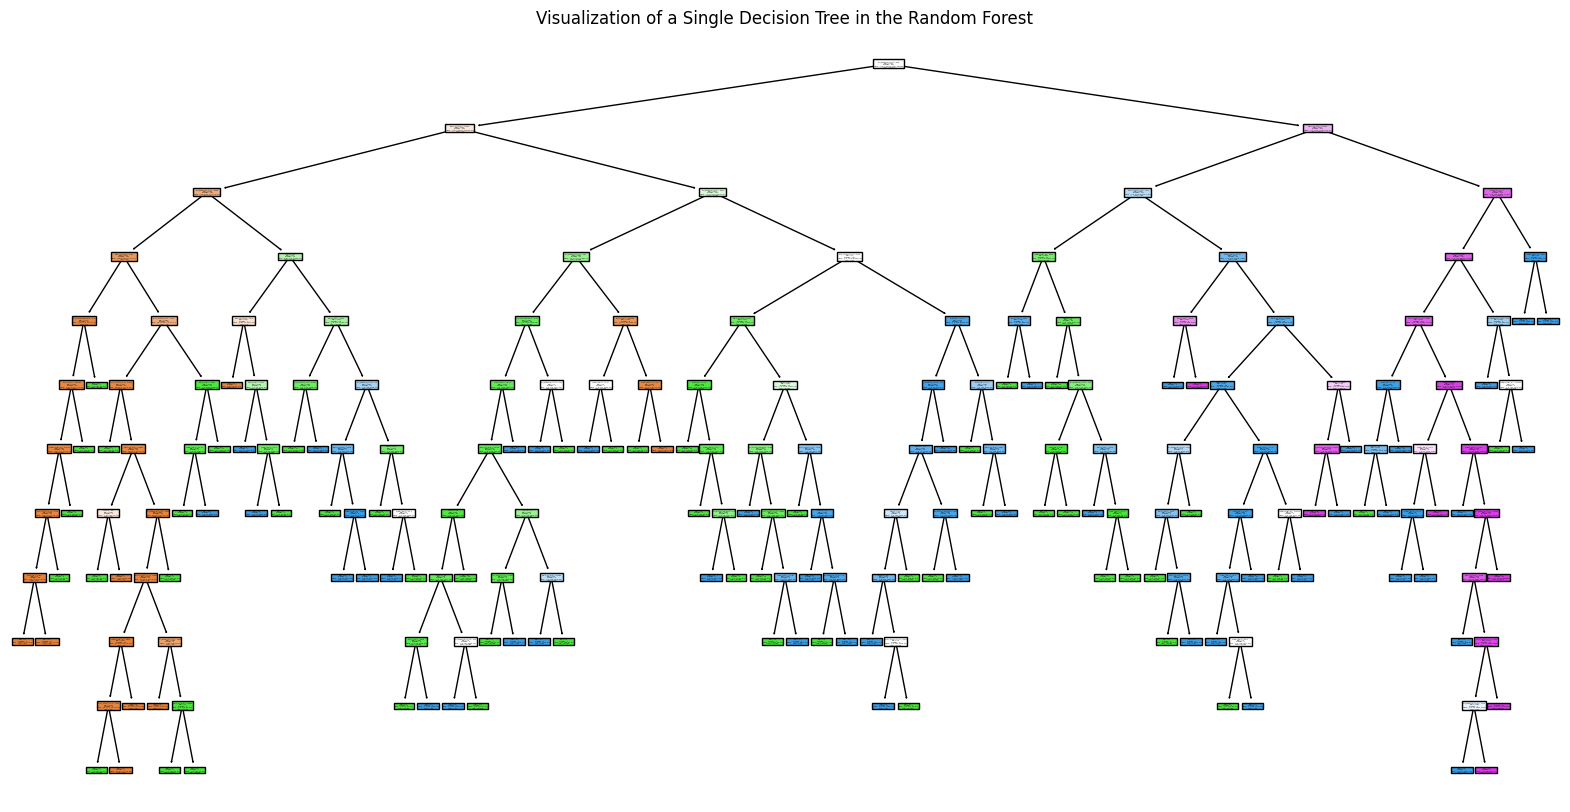

In [72]:
from sklearn.tree import export_graphviz
import graphviz
from sklearn.tree import plot_tree

# Select a single tree from the Random Forest
tree = rf_model.estimators_[0]

# Plot the tree
plt.figure(figsize=(20, 10))
plot_tree(tree, feature_names=feature_names, class_names=['Low', 'Medium', 'High', 'Premium'], filled=True)
plt.title("Visualization of a Single Decision Tree in the Random Forest")
plt.show()


#### Shap Visualisation

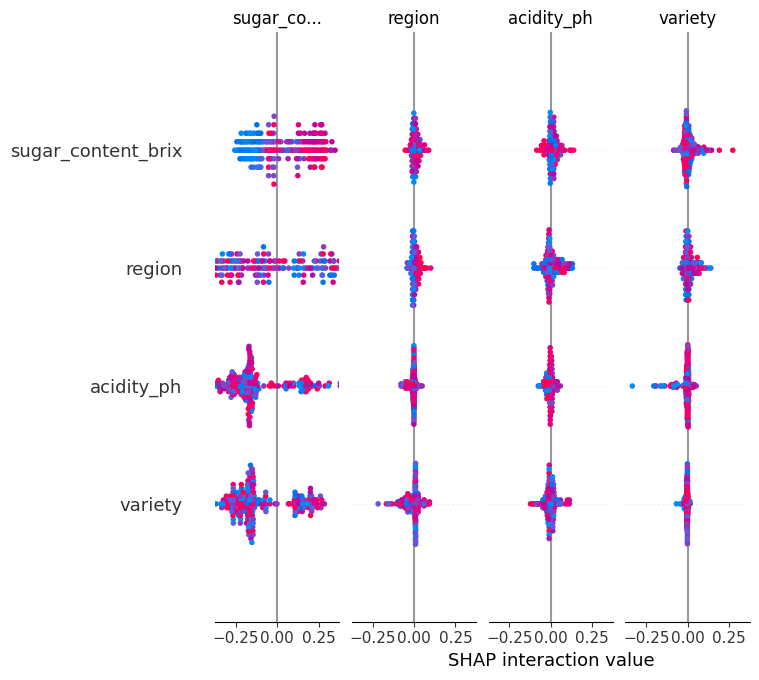

In [74]:
import shap

# Initialize the SHAP explainer
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_validation)

# Plot summary of SHAP values for all features
shap.summary_plot(shap_values, X_validation, plot_type="bar", class_names=['Low', 'Medium', 'High', 'Premium'])


AssertionError: 'shap_values' and 'features' values must have the same number of rows!

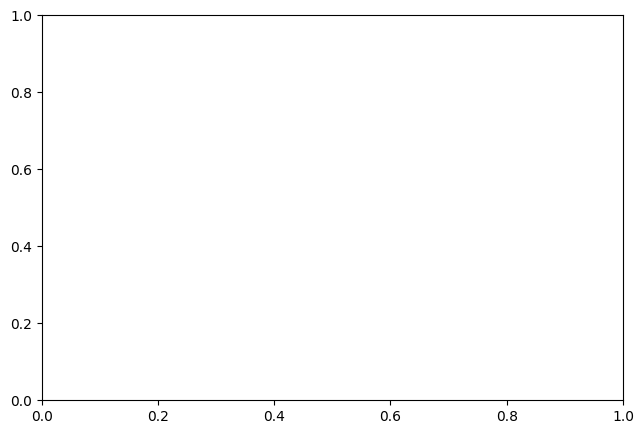

In [75]:
# Example: SHAP dependence plot for a specific feature
shap.dependence_plot("sugar_content_brix", shap_values[1], X_validation, interaction_index="acidity_ph")